In [1]:
#default_exp core

In [2]:
#hide
%load_ext autoreload
%autoreload 2

# Core

In [3]:
#hide
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
#export
import inspect
import logging
from functools import partial
from os import cpu_count

import numpy as np
import pandas as pd

In [5]:
#exporti
logging.basicConfig(
    format='%(asctime)s %(name)s %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
)
logger = logging.getLogger(__name__)

In [6]:
#hide
logger.setLevel(logging.ERROR)

In [7]:
from fastcore.test import test_eq

from statsforecast.models import (
    adida,
    auto_arima,
    croston_classic,
    croston_optimized,
    croston_sba,
    historic_average,
    imapa,
    naive,
    random_walk_with_drift,
    seasonal_exponential_smoothing,
    seasonal_naive,
    seasonal_window_average,
    ses,
    tsb,
    window_average,
)
from statsforecast.utils import generate_series

In [22]:
#exporti
class GroupedArray:
    
    def __init__(self, data, indptr):
        self.data = data
        self.indptr = indptr
        self.n_groups = self.indptr.size - 1
        
    def __getitem__(self, idx):
        if isinstance(idx, int):
            return self.data[self.indptr[idx] : self.indptr[idx + 1]]
        elif isinstance(idx, slice):
            idx = slice(idx.start, idx.stop + 1, idx.step)
            new_indptr = self.indptr[idx].copy()
            new_data = self.data[new_indptr[0] : new_indptr[-1]].copy()            
            new_indptr -= new_indptr[0]
            return GroupedArray(new_data, new_indptr)
        raise ValueError(f'idx must be either int or slice, got {type(idx)}')
    
    def __len__(self):
        return self.n_groups
    
    def __repr__(self):
        return f'GroupedArray(n_data={self.data.size:,}, n_groups={self.n_groups:,})'
    
    def __eq__(self, other):
        if not hasattr(other, 'data') or not hasattr(other, 'indptr'):
            return False
        return np.allclose(self.data, other.data) and np.array_equal(self.indptr, other.indptr)
    
    def compute_forecasts(self, h, func, xreg=None, level=None, *args):
        has_level = 'level' in inspect.signature(func).parameters and level is not None
        if has_level:
            out = np.full((h * self.n_groups, 2 * len(level) + 1), np.nan, dtype=np.float32)
            func = partial(func, level=level)
        else:
            out = np.full(h * self.n_groups, np.nan, dtype=np.float32)
        xr = None
        keys = None
        for i, grp in enumerate(self):
            if xreg is not None:
                xr = xreg[i]
            res = func(grp, h, xr, *args)                
            if has_level:
                if keys is None:
                    keys = list(res.keys())
                for j, key in enumerate(keys):
                    out[h * i : h * (i + 1), j] = res[key]
            else:
                out[h * i : h * (i + 1)] = res
        return out, keys
    
    def compute_cv(self, h, test_size, func, input_size=None, *args):
        # output of size: (ts, window, h)
        # assuming step_size = 1 for the moment
        n_windows = test_size - h + 1
        out = np.full((self.n_groups, n_windows, h), np.nan, dtype=np.float32)
        out_test = np.full((self.n_groups, n_windows, h), np.nan, dtype=np.float32)
        for i_ts, grp in enumerate(self):
            for i_window in range(n_windows):
                cutoff = -test_size + i_window
                end_cutoff = cutoff + h
                y_train = grp[(cutoff - input_size):cutoff] if input_size is not None else grp[:cutoff]
                y_test = grp[cutoff:] if end_cutoff == 0 else grp[cutoff:end_cutoff]
                out[i_ts, i_window] = func(y_train, h, None, *args)
                out_test[i_ts, i_window] = y_test.flatten()
        
        return out, out_test

    def split(self, n_chunks):
        return [self[x[0] : x[-1] + 1] for x in np.array_split(range(self.n_groups), n_chunks) if x.size]

In [23]:
#hide
data = np.arange(12)
indptr = np.array([0, 4, 8, 12])
ga = GroupedArray(data, indptr)

test_eq(len(ga), 3)
np.testing.assert_equal(
    ga.compute_forecasts(2, naive)[0],
    np.hstack([2 * [data[i]] for i in indptr[1:] - 1]),
)
splits = ga.split(2)
test_eq(splits[0], GroupedArray(data[:8], indptr[:3]))
test_eq(splits[1], GroupedArray(data[8:], np.array([0, 4])))

In [53]:
#hide
data = np.hstack([np.arange(10), np.arange(100, 200), np.arange(20, 40)])
indptr = np.array([0, 10, 110, 130])
ga = GroupedArray(data, indptr)
def sum_ahead(x, h, xreg):
    return x[-1] + np.arange(1, h + 1)
y_hat, y_test = ga.compute_cv(h=2, test_size=5, func=sum_ahead)
np.testing.assert_equal(y_hat, y_test)

In [54]:
#exporti
def _grouped_array_from_df(df):
    df = df.set_index('ds', append=True)
    if not df.index.is_monotonic_increasing:
        df = df.sort_index()
    data = df.values.astype(np.float32)
    indices_sizes = df.index.get_level_values('unique_id').value_counts(sort=False)
    indices = indices_sizes.index
    sizes = indices_sizes.values
    cum_sizes = sizes.cumsum()
    dates = df.index.get_level_values('ds')[cum_sizes - 1]
    indptr = np.append(0, cum_sizes).astype(np.int32)
    return GroupedArray(data, indptr), indices, dates

In [55]:
#hide
series = generate_series(10_000, n_static_features=2, equal_ends=False)
sorted_series = series.sort_values(['unique_id', 'ds'])
unsorted_series = sorted_series.sample(frac=1.0)
ga, indices, dates = _grouped_array_from_df(unsorted_series)

np.testing.assert_allclose(ga.data, sorted_series.drop(columns='ds').values)
test_eq(indices, sorted_series.index.unique(level='unique_id'))
test_eq(dates, series.groupby('unique_id')['ds'].max().values)

In [64]:
def _cv_dates(last_dates, freq, h, test_size):
    #assuming step_size = 1
    n_windows = test_size - h + 1
    if len(np.unique(last_dates)) == 1:
        total_dates = pd.date_range(end=last_dates[0], periods=test_size, freq=freq)
        out = np.empty((h * n_windows, 2), dtype='datetime64[s]')
        for i_window in range(n_windows):
            out[h * i_window : h * (i_window + 1), 0] = total_dates[i_window:(i_window + h)]
            out[h * i_window : h * (i_window + 1), 1] = np.tile(total_dates[i_window] - freq * 1, h)
        dates = pd.DataFrame(np.tile(out, (len(last_dates), 1)), columns=['ds', 'cutoff'])
    else:
        dates = pd.concat([_cv_dates([ld], freq, h, test_size) for ld in last_dates])
        dates = dates.reset_index(drop=True)
    return dates

In [84]:
#hide
for e_e in [True, False]:
    n_series = 2
    series = generate_series(n_series, equal_ends=e_e)
    ga, indices, dates = _grouped_array_from_df(series)
    freq = pd.tseries.frequencies.to_offset('D')
    horizon = 3
    test_size = 5
    df_dates = _cv_dates(last_dates=dates, freq=freq, h=horizon, test_size=test_size)
    test_eq(len(df_dates), n_series * horizon * (test_size - horizon + 1)) 

In [85]:
#exporti
def _build_forecast_name(model, *args) -> str:
    model_name = f'{model.__name__}'
    func_params = inspect.signature(model).parameters
    func_args = list(func_params.items())[3:]  # remove input array, horizon and xreg
    changed_params = [
        f'{name}-{value}'
        for value, (name, arg) in zip(args, func_args)
        if arg.default != value
    ]
    if changed_params:
        model_name += '_' + '_'.join(changed_params)
    return model_name

In [86]:
#hide
test_eq(_build_forecast_name(ses, 0.1), 'ses_alpha-0.1')
test_eq(_build_forecast_name(seasonal_window_average, 7, 4), 'seasonal_window_average_season_length-7_window_size-4')

In [87]:
#exporti
def _as_tuple(x):
    if isinstance(x, tuple):
        return x
    return (x,)

In [88]:
#hide
test_eq(_as_tuple((1,)), (1,))
test_eq(_as_tuple(1), (1,))

In [89]:
#exporti
def _get_n_jobs(n_groups, n_jobs, ray_address):
    if ray_address is not None:
        logger.info(
            'Using ray address,'
            'using available resources insted of `n_jobs`'
        )
        try:
            import ray
        except ModuleNotFoundError as e:
            msg = (
                '{e}. To use a ray cluster you have to install '
                'ray. Please run `pip install ray`. '
            )
            raise ModuleNotFoundError(msg) from e
        if not ray.is_initialized():
            ray.init(ray_address, ignore_reinit_error=True)
        actual_n_jobs = int(ray.available_resources()['CPU'])
    else:
        if n_jobs == -1 or (n_jobs is None):
            actual_n_jobs = cpu_count()
        else:
            actual_n_jobs = n_jobs
    return min(n_groups, actual_n_jobs)

In [90]:
#hide
#tests for more series than resources
test_eq(_get_n_jobs(10, -1, None), cpu_count()) 
test_eq(_get_n_jobs(10, None, None), cpu_count())
test_eq(_get_n_jobs(10, 2, None), 2)

In [91]:
#hide
#tests for less series than resources
test_eq(_get_n_jobs(1, -1, None), 1) 
test_eq(_get_n_jobs(1, None, None), 1)
test_eq(_get_n_jobs(2, 10, None), 2)

In [97]:
#export
class StatsForecast:
    
    def __init__(self, df, models, freq, n_jobs=1, ray_address=None):
        self.ga, self.uids, self.last_dates = _grouped_array_from_df(df)
        self.models = models
        self.freq = pd.tseries.frequencies.to_offset(freq)
        self.n_jobs = _get_n_jobs(len(self.ga), n_jobs, ray_address)
        self.ray_address = ray_address
        
    def forecast(self, h, xreg=None, level=None):
        if xreg is not None:
            expected_shape = (h * len(self.ga), self.ga.data.shape[1])
            if xreg.shape != expected_shape:
                raise ValueError(f'Expected xreg to have shape {expected_shape}, but got {xreg.shape}')
            xreg, _, _ = _grouped_array_from_df(xreg)
        forecast_kwargs = dict(
            h=h, test_size=None, input_size=None, 
            xreg=xreg, level=level, mode='forecast',
        )
        if self.n_jobs == 1:
            fcsts = self._sequential(**forecast_kwargs)
        else:
            fcsts = self._data_parallel(**forecast_kwargs)
        if issubclass(self.last_dates.dtype.type, np.integer):
            last_date_f = lambda x: np.arange(x + 1, x + 1 + h, dtype=self.last_dates.dtype)
        else:
            last_date_f = lambda x: pd.date_range(x + self.freq, periods=h, freq=self.freq)
        if len(np.unique(self.last_dates)) == 1:
            dates = np.tile(last_date_f(self.last_dates[0]), len(self.ga))
        else:
            dates = np.hstack([
                last_date_f(last_date)
                for last_date in self.last_dates            
            ])
        idx = pd.Index(np.repeat(self.uids, h), name='unique_id')
        return pd.DataFrame({'ds': dates, **fcsts}, index=idx)
        
    def _sequential(self, h, test_size, input_size, xreg, level, mode='forecast'):
        fcsts = {}
        logger.info('Computing forecasts')
        for model_args in self.models:
            model, *args = _as_tuple(model_args)
            model_name = _build_forecast_name(model, *args)
            if mode == 'forecast':
                values, keys = self.ga.compute_forecasts(h, model, xreg, level, *args)
            if keys is not None:
                for j, key in enumerate(keys):
                    fcsts[f'{model_name}_{key}'] = values[:, j]
            else:
                fcsts[model_name] = values
            logger.info(f'Computed forecasts for {model_name}.')
        return fcsts
    
    def _data_parallel(self, h, test_size, input_size, xreg, level, mode='forecast'):
        fcsts = {}
        logger.info('Computing forecasts')
        gas = self.ga.split(self.n_jobs)
        if xreg is not None:
            xregs = xreg.split(self.n_jobs)
        else:
            from itertools import repeat
            
            xregs = repeat(None)
        
        if self.ray_address is not None:
            try:
                from ray.util.multiprocessing import Pool
            except ModuleNotFoundError as e:
                msg = (
                    f'{e}. To use a ray cluster you have to install '
                    'ray. Please run `pip install ray`. '
                )
                raise ModuleNotFoundError(msg) from e
            kwargs = dict(ray_address=self.ray_address)
        else:
            from multiprocessing import Pool
            kwargs = dict()
        
        with Pool(self.n_jobs, **kwargs) as executor:
            for model_args in self.models:
                model, *args = _as_tuple(model_args)
                model_name = _build_forecast_name(model, *args)
                futures = []
                for ga, xr in zip(gas, xregs):
                    if mode == 'forecast':
                        future = executor.apply_async(ga.compute_forecasts, (h, model, xr, level, *args,))
                    futures.append(future)
                values, keys = list(zip(*[f.get() for f in futures]))
                keys = keys[0]
                if keys is not None:
                    values = np.vstack(values)
                    for j, key in enumerate(keys):
                        fcsts[f'{model_name}_{key}'] = values[:, j]
                else:
                    values = np.hstack(values)
                    fcsts[model_name] = values
                logger.info(f'Computed forecasts for {model_name}.')
        return fcsts
    



## Daily data

In [98]:
fcst = StatsForecast(
    series,
    [adida, croston_classic, croston_optimized,
     croston_sba, historic_average, imapa, naive, 
     random_walk_with_drift, (seasonal_exponential_smoothing, 7, 0.1),
     (seasonal_naive, 7), (seasonal_window_average, 7, 4),
     (ses, 0.1), (tsb, 0.1, 0.3), (window_average, 4)],
    freq='D',
)
res = fcst.forecast(14)
res

,ds,adida,croston_classic,croston_optimized,croston_sba,historic_average,imapa,naive,random_walk_with_drift,seasonal_exponential_smoothing_season_length-7_alpha-0.1,seasonal_naive_season_length-7,seasonal_window_average_season_length-7_window_size-4,ses_alpha-0.1,tsb_alpha_d-0.1_alpha_p-0.3,window_average_window_size-4
unique_id,,,,,,,,,,,,,,,
0,2000-08-10,3.180249,3.180249,3.180249,3.021237,3.226516,3.180249,4.136771,4.153872,0.193774,5.160008,5.260612,3.180249,3.180249,2.825778
0,2000-08-11,3.180249,3.180249,3.180249,3.021237,3.226516,3.180249,4.136771,4.170972,1.288320,6.191732,6.222603,3.180249,3.180249,2.825778
0,2000-08-12,3.180249,3.180249,3.180249,3.021237,3.226516,3.180249,4.136771,4.188072,2.249821,0.294159,0.135531,3.180249,3.180249,2.825778
0,2000-08-13,3.180249,3.180249,3.180249,3.021237,3.226516,3.180249,4.136771,4.205173,3.259701,1.415524,1.202426,3.180249,3.180249,2.825778
0,2000-08-14,3.180249,3.180249,3.180249,3.021237,3.226516,3.180249,4.136771,4.222273,4.230496,2.314491,2.250764,3.180249,3.180249,2.825778
0,2000-08-15,3.180249,3.180249,3.180249,3.021237,3.226516,3.180249,4.136771,4.239373,5.260778,3.436325,3.207349,3.180249,3.180249,2.825778
0,2000-08-16,3.180249,3.180249,3.180249,3.021237,3.226516,3.180249,4.136771,4.256474,6.251182,4.136771,4.283105,3.180249,3.180249,2.825778
0,2000-08-17,3.180249,3.180249,3.180249,3.021237,3.226516,3.180249,4.136771,4.273574,0.193774,5.160008,5.260612,3.180249,3.180249,2.825778
0,2000-08-18,3.180249,3.180249,3.180249,3.021237,3.226516,3.180249,4.136771,4.290674,1.288320,6.191732,6.222603,3.180249,3.180249,2.825778


In [99]:
#hide
test_eq(res.index.unique(), fcst.uids)
last_dates = series.groupby('unique_id')['ds'].max()
test_eq(res.groupby('unique_id')['ds'].min().values, last_dates + pd.offsets.Day())
test_eq(res.groupby('unique_id')['ds'].max().values, last_dates + 14 * pd.offsets.Day())

### Equal ends

In [100]:
series_eq_ends = generate_series(10_000, equal_ends=True)

In [101]:
fcst = StatsForecast(
    series_eq_ends,
    [adida, croston_classic, croston_optimized,
     croston_sba, historic_average, imapa, naive, 
     random_walk_with_drift, (seasonal_exponential_smoothing, 7, 0.1),
     (seasonal_naive, 7), (seasonal_window_average, 7, 4),
     (ses, 0.1), (tsb, 0.1, 0.3), (window_average, 4)],
    freq='D',
)
res = fcst.forecast(14)
res

,ds,adida,croston_classic,croston_optimized,croston_sba,historic_average,imapa,naive,random_walk_with_drift,seasonal_exponential_smoothing_season_length-7_alpha-0.1,seasonal_naive_season_length-7,seasonal_window_average_season_length-7_window_size-4,ses_alpha-0.1,tsb_alpha_d-0.1_alpha_p-0.3,window_average_window_size-4
unique_id,,,,,,,,,,,,,,,
0,2001-05-15,3.151185,3.151185,3.151185,2.993625,3.220805,3.151185,4.303774,4.322688,0.230120,5.407726,5.168735,3.151185,3.151185,2.681427
0,2001-05-16,3.151185,3.151185,3.151185,2.993625,3.220805,3.151185,4.303774,4.341602,1.304269,6.333432,6.318525,3.151185,3.151185,2.681427
0,2001-05-17,3.151185,3.151185,3.151185,2.993625,3.220805,3.151185,4.303774,4.360516,2.198268,0.301776,0.222002,3.151185,3.151185,2.681427
0,2001-05-18,3.151185,3.151185,3.151185,2.993625,3.220805,3.151185,4.303774,4.379429,3.175688,1.340912,1.267534,3.151185,3.151185,2.681427
0,2001-05-19,3.151185,3.151185,3.151185,2.993625,3.220805,3.151185,4.303774,4.398343,4.209983,2.032122,2.235913,3.151185,3.151185,2.681427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,2001-05-24,3.651947,3.651947,3.651947,3.469350,3.261435,3.651947,6.238846,6.241093,1.156649,2.338823,2.188838,3.651947,3.651947,4.771874
9999,2001-05-25,3.651947,3.651947,3.651947,3.469350,3.261435,3.651947,6.238846,6.241318,2.247917,3.402687,3.266871,3.651947,3.651947,4.771874
9999,2001-05-26,3.651947,3.651947,3.651947,3.469350,3.261435,3.651947,6.238846,6.241543,3.252458,4.235569,4.234198,3.651947,3.651947,4.771874


In [102]:
#hide
test_eq(res.index.unique(), fcst.uids)
last_dates = series_eq_ends.groupby('unique_id')['ds'].max()
test_eq(res.groupby('unique_id')['ds'].min().values, last_dates + pd.offsets.Day())
test_eq(res.groupby('unique_id')['ds'].max().values, last_dates + 14 * pd.offsets.Day())

### Parallel

In [103]:
try: from nbdev.imports import IN_NOTEBOOK
except: IN_NOTEBOOK=False
if __name__=="__main__" and not IN_NOTEBOOK:
    fcst = StatsForecast(
        series,
        [adida, (ses, 0.1), historic_average, croston_classic],
        freq='D',
        n_jobs=2
    )
    res = fcst.forecast(14)
    print(res)

## Monthly data

In [104]:
monthly_series = generate_series(10_000, freq='M', min_length=10, max_length=20, equal_ends=True)
monthly_series

,ds,y
unique_id,,
0,2000-06-30,0.317078
0,2000-07-31,1.183993
0,2000-08-31,2.458650
0,2000-09-30,3.396637
0,2000-10-31,4.160418
...,...,...
9999,2001-04-30,7.087452
9999,2001-05-31,8.106541
9999,2001-06-30,9.162334


In [105]:
fcst = StatsForecast(
    monthly_series,
    [adida, (ses, 0.1), historic_average, croston_classic],
    freq='M'
)
%time monthly_res = fcst.forecast(4)
monthly_res

CPU times: user 2.3 s, sys: 5.14 ms, total: 2.3 s
Wall time: 2.3 s


,ds,adida,ses_alpha-0.1,historic_average,croston_classic
unique_id,,,,,
0,2001-09-30,4.069533,4.101110,4.895469,4.101110
0,2001-10-31,4.069533,4.101110,4.895469,4.101110
0,2001-11-30,4.069533,4.101110,4.895469,4.101110
0,2001-12-31,4.069533,4.101110,4.895469,4.101110
1,2001-09-30,6.407427,5.631709,6.588876,5.631709
...,...,...,...,...,...
9998,2001-12-31,4.352780,5.783700,5.083481,5.783700
9999,2001-09-30,7.166113,7.166113,6.789791,7.166113
9999,2001-10-31,7.166113,7.166113,6.789791,7.166113


In [106]:
fcst.ga.split(2)[1].data

array([[ 5.039017 ],
       [ 6.4191217],
       [ 7.143789 ],
       ...,
       [ 9.162334 ],
       [10.052649 ],
       [11.327798 ]], dtype=float32)

In [107]:
#hide
last_dates = monthly_series.groupby('unique_id')['ds'].max()
test_eq(monthly_res.groupby('unique_id')['ds'].min().values, fcst.last_dates + pd.offsets.MonthEnd())
test_eq(monthly_res.groupby('unique_id')['ds'].max().values, fcst.last_dates + 4 * pd.offsets.MonthEnd())

## Integer datestamp

In [108]:
from statsforecast.utils import AirPassengers as ap

In [109]:
int_ds_df = pd.DataFrame({'ds': np.arange(1, len(ap) + 1), 'y': ap})
int_ds_df.insert(0, 'unique_id', 'AirPassengers')
int_ds_df.set_index('unique_id', inplace=True)
int_ds_df.head()

,ds,y
unique_id,,
AirPassengers,1,112.0
AirPassengers,2,118.0
AirPassengers,3,132.0
AirPassengers,4,129.0
AirPassengers,5,121.0


In [110]:
int_ds_df.tail()

,ds,y
unique_id,,
AirPassengers,140,606.0
AirPassengers,141,508.0
AirPassengers,142,461.0
AirPassengers,143,390.0
AirPassengers,144,432.0


In [111]:
fcst = StatsForecast(int_ds_df, models=[historic_average], freq='D')
horizon = 7
forecast = fcst.forecast(horizon)
forecast.head()

,ds,historic_average
unique_id,,
AirPassengers,145,280.298615
AirPassengers,146,280.298615
AirPassengers,147,280.298615
AirPassengers,148,280.298615
AirPassengers,149,280.298615


In [112]:
last_date = int_ds_df['ds'].max()
test_eq(forecast['ds'].values, np.arange(last_date + 1, last_date + 1 + horizon))

## External regressors

Every column after **y** is considered an external regressor and will be passed to the models that allow them. If you use them you must supply the future values to the `forecast` method.

In [113]:
def linear_regression(X, h, future_xreg):
    y = X[:, 0]
    xreg = X[:, 1:]
    coefs, *_ = np.linalg.lstsq(xreg, y, rcond=None)
    return future_xreg @ coefs

In [114]:
series_xreg = series = generate_series(10_000, equal_ends=True)
series_xreg['intercept'] = 1
series_xreg['dayofweek'] = series_xreg['ds'].dt.dayofweek
series_xreg = pd.get_dummies(series_xreg, columns=['dayofweek'], drop_first=True)
series_xreg

,ds,y,intercept,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
unique_id,,,,,,,,,
0,2000-10-05,0.123838,1,0,0,1,0,0,0
0,2000-10-06,1.460113,1,0,0,0,1,0,0
0,2000-10-07,2.418577,1,0,0,0,0,1,0
0,2000-10-08,3.372232,1,0,0,0,0,0,1
0,2000-10-09,4.241948,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9999,2001-05-10,2.338823,1,0,0,1,0,0,0
9999,2001-05-11,3.402687,1,0,0,0,1,0,0
9999,2001-05-12,4.235569,1,0,0,0,0,1,0


In [115]:
dates = sorted(series_xreg['ds'].unique())
valid_start = dates[-14]
train_mask = series_xreg['ds'] < valid_start
series_train = series_xreg[train_mask]
series_valid = series_xreg[~train_mask]
X_valid = series_valid.drop(columns=['y'])
fcst = StatsForecast(
    series_train,
    [linear_regression],
    freq='D',
)
%time xreg_res = fcst.forecast(14, xreg=X_valid)
xreg_res['y'] = series_valid['y'].values

CPU times: user 2.08 s, sys: 11.5 ms, total: 2.1 s
Wall time: 2.1 s


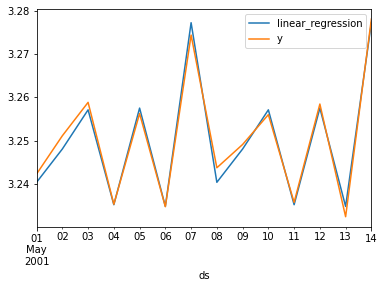

In [116]:
xreg_res.groupby('ds').mean().plot();

## Confidence intervals

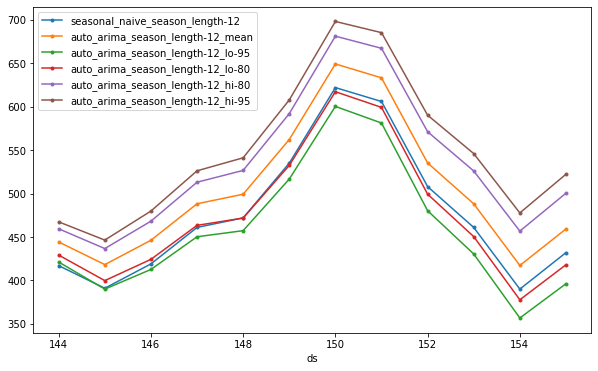

In [117]:
ap_df = pd.DataFrame({'ds': np.arange(ap.size), 'y': ap}, index=pd.Index([0] * ap.size, name='unique_id'))
fcst = StatsForecast(
    ap_df,
    [(seasonal_naive, 12), (auto_arima, 12)],
    freq='M',
)
ap_ci = fcst.forecast(12, level=(80, 95))
ap_ci.set_index('ds').plot(marker='.', figsize=(10, 6));

## n jobs

In [118]:
ap_df_2 = pd.DataFrame(
    {'ds': np.hstack([np.arange(ap.size), np.arange(ap.size)]), 
     'y': np.hstack([ap, ap])}, 
    index=pd.Index([0] * ap.size + [1] * ap.size, name='unique_id')
)

In [119]:
if __name__=="__main__" and not IN_NOTEBOOK:
    ap_df = pd.DataFrame({'ds': np.arange(ap.size), 'y': ap}, index=pd.Index([0] * ap.size, name='unique_id'))
    fcst = StatsForecast(
        ap_df,
        [(seasonal_naive, 12), (auto_arima, 12)],
        freq='M',
        n_jobs=101
    )
    ap_ci = fcst.forecast(12, level=(80, 95))
    ap_ci.set_index('ds').plot(marker='.', figsize=(10, 6))

In [120]:
#hide
def return_xreg(X, h, xreg, *args):
    return xreg[:, 0]

In [121]:
#hide
df = pd.DataFrame(
    {
        'ds': np.hstack([np.arange(10), np.arange(10)]),
        'y': np.random.rand(20),
        'x': np.arange(20, dtype=np.float32),
    },
    index=pd.Index([0] * 10 + [1] * 10, name='unique_id'),
)
train_mask = df['ds'] < 6
train_df = df[train_mask]
test_df = df[~ train_mask]

In [122]:
#hide
fcst = StatsForecast(
    train_df,
    [return_xreg],
    freq='M',
    n_jobs=1,
)
xreg = test_df.drop(columns='y')
res = fcst.forecast(4, xreg=xreg)
expected_res = xreg.rename(columns={'x': 'return_xreg'})
pd.testing.assert_frame_equal(res, expected_res, check_dtype=False)

In [123]:
#hide
if __name__=="__main__" and not IN_NOTEBOOK:
    fcst = StatsForecast(
        train_df,
        [return_xreg],
        freq='M',
        n_jobs=2,
    )
    xreg = test_df.drop(columns='y')
    res = fcst.forecast(4, xreg=xreg)
    expected_res = xreg.rename(columns={'x': 'return_xreg'})
    pd.testing.assert_frame_equal(res, expected_res, check_dtype=False)